In [ ]:
# Exemple : se connecter à Neo4j, récupérer les attributs de tous les nœuds,
# construire des DataFrame par label et afficher les noms des DataFrame.

# Pré-requis :
# pip install neo4j pandas

from neo4j import GraphDatabase
import pandas as pd
from collections import defaultdict

# Paramètres de connexion - remplacez par vos valeurs
URI = "neo4j://localhost:7687"
USER = "neo4j"
PASSWORD = "plbconsultant"

driver = GraphDatabase.driver(URI, auth=(USER, PASSWORD))

query = """
MATCH (n)
RETURN id(n) AS _id, labels(n) AS labels, properties(n) AS props
"""

records = []
with driver.session() as session:
    result = session.run(query)
    for rec in result:
        records.append({
            "_id": rec["_id"],
            "labels": rec["labels"],
            "props": rec["props"] or {}
        })

# Construire un DataFrame "all" contenant tous les nœuds
all_rows = []
for r in records:
    row = {"_id": r["_id"], **r["props"]}
    all_rows.append(row)
df_all = pd.DataFrame(all_rows)

# Construire des DataFrame distincts par label
rows_by_label = defaultdict(list)
for r in records:
    base = {"_id": r["_id"], **r["props"]}
    for label in r["labels"]:
        rows_by_label[label].append(base.copy())

label_dfs = {label: pd.DataFrame(rows) for label, rows in rows_by_label.items()}

driver.close()

# Affichage : noms des DataFrame créés
print("DataFrame global : df_all (toutes les propriétés, longueur {})".format(len(df_all)))
print("DataFrames par label :")
for label, df in label_dfs.items():
    print(f"- {label} : {df.shape[0]} lignes, {df.shape[1]} colonnes")

# Exemple d'accès :
# df_all.head()
# label_dfs['Person'].head()   # si label 'Person' existe


Received notification from DBMS server: <GqlStatusObject gql_status='01N02', status_description='warn: feature deprecated without replacement. id is deprecated and will be removed without a replacement.', position=<SummaryInputPosition line=3, column=8, offset=18>, raw_classification='DEPRECATION', classification=<NotificationClassification.DEPRECATION: 'DEPRECATION'>, raw_severity='WARNING', severity=<NotificationSeverity.WARNING: 'WARNING'>, diagnostic_record={'_classification': 'DEPRECATION', '_severity': 'WARNING', '_position': {'offset': 18, 'line': 3, 'column': 8}, 'OPERATION': '', 'OPERATION_CODE': '0', 'CURRENT_SCHEMA': '/'}> for query: '\nMATCH (n)\nRETURN id(n) AS _id, labels(n) AS labels, properties(n) AS props\n'


DataFrame global : df_all (toutes les propriétés, longueur 213)
DataFrames par label :
- Character : 68 lignes, 2 colonnes
- Person : 123 lignes, 6 colonnes
- Actor : 51 lignes, 5 colonnes
- Movie : 22 lignes, 6 colonnes


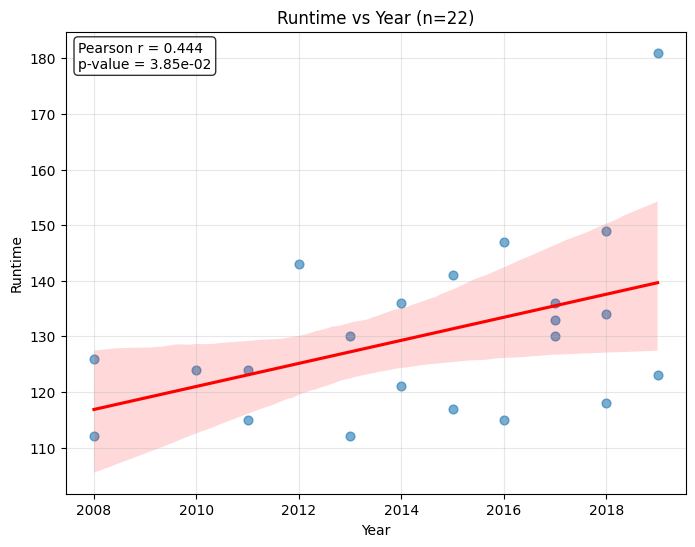

Observations valides : 22
Pearson r = 0.444, p-value = 3.85e-02


In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
import numpy as np

# Vérifier que les colonnes existent
if not {'runtime', 'year'}.issubset(df_all.columns):
    print("Les colonnes 'runtime' et/ou 'year' sont absentes de df_all")
else:
    # Préparer le dataframe : convertir en numerique et supprimer les NaN
    df_plot = df_all[['runtime', 'year']].copy()
    df_plot['runtime'] = pd.to_numeric(df_plot['runtime'], errors='coerce')
    df_plot['year'] = pd.to_numeric(df_plot['year'], errors='coerce')
    df_plot = df_plot.dropna()

    # Filtrage optionnel sur valeurs réalistes
    df_plot = df_plot[(df_plot['runtime'] > 0) & (df_plot['runtime'] < 1000) &
                      (df_plot['year'] >= 1800) & (df_plot['year'] <= 2100)]

    n = len(df_plot)
    if n < 2:
        print("Pas suffisamment de points valides pour calculer une corrélation (n < 2).")
    else:
        # Coefficient de Pearson
        r, p = pearsonr(df_plot['year'], df_plot['runtime'])

        # Trace
        plt.figure(figsize=(8,6))
        sns.regplot(x='year', y='runtime', data=df_plot, scatter_kws={'alpha':0.6, 's':40}, line_kws={'color':'red'})
        plt.title(f'Runtime vs Year (n={n})')
        plt.xlabel('Year')
        plt.ylabel('Runtime')
        plt.grid(alpha=0.3)

        # Annotation du coefficient
        plt.annotate(f'Pearson r = {r:.3f}\np-value = {p:.2e}', xy=(0.02, 0.98),
                     xycoords='axes fraction', ha='left', va='top',
                     bbox=dict(boxstyle='round', fc='white', alpha=0.8))

        plt.show()

        # Résumé
        print(f"Observations valides : {n}")
        print(f"Pearson r = {r:.3f}, p-value = {p:.2e}")
